In [7]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import pandas as pd
import transformers
from transformers import BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader


In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_accuracy(train_acc, test_acc):
    acc = train_acc
    val_acc = test_acc
    # loss = history.history['loss']
    # val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    # plt.figure(figsize=(12, 5))
    # plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    # plt.subplot(1, 2, 2)
    # plt.plot(x, loss, 'b', label='Training loss')
    # plt.plot(x, val_loss, 'r', label='Validation loss')
    # plt.title('Training and validation loss')
    # plt.legend()

In [10]:
# Reading Data
#df = pd.read_csv("finbank_data.csv")
encoder = LabelEncoder()
#labels = encoder.fit_transform(df.label)

In [11]:
# Reading Data (Part II) split the data into three parts
df_train = pd.read_csv("finbank_data_train.csv")
df_test = pd.read_csv("finbank_data_test.csv")
df_val = pd.read_csv("finbank_data_val.csv")

"""
df = df_train
df.append(df_val, ignore_index=True)
df.append(df_test, ignore_index=True)

encoder = LabelEncoder()
encoder = encoder.fit(df.label)
"""

'\ndf = df_train\ndf.append(df_val, ignore_index=True)\ndf.append(df_test, ignore_index=True)\n\nencoder = LabelEncoder()\nencoder = encoder.fit(df.label)\n'

In [42]:
X_train = df_train.text
Y_train = encoder.fit_transform(df_train.label)
X_test = df_test.text
Y_test = encoder.fit_transform(df_test.label)

X_val = df_val.text
Y_val = encoder.fit_transform(df_val.label)

[2 0 1 ... 1 2 1]
0       positive
1       negative
2        neutral
3        neutral
4        neutral
          ...   
4668     neutral
4669    positive
4670     neutral
4671    positive
4672     neutral
Name: label, Length: 4673, dtype: object


In [13]:
# Init tokenizer
# Bert has its own tokenizer which also include some special tokens
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Spliting data
#_train, X_test, y_train, y_test = train_test_split(df.text.values, labels, test_size=.2, stratify=df.label.values)

In [14]:
# Data generator
# Inherit Dataset from torch which need to implement __len__ and __getitem__ function

class Datagen(Dataset):
    def __init__(self, sentence, target, tokenizer, max_len):
        self.sentence = sentence
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)
    
    def __getitem__(self, idx):
        sentence = self.sentence[idx]
        bert_encoding = tokenizer.encode_plus(
            sentence, 
            max_length = self.max_len, 
            add_special_tokens = True, # include special tokens
            padding = 'max_length', 
            truncation = True, 
            return_attention_mask = True, # return attention mask which is required during training 
            return_token_type_ids = False, 
            return_tensors = 'pt' # pt is pytorch format tensor
        )
        return {
            "input_ids": torch.squeeze(bert_encoding["input_ids"]),
            "attention_mask": torch.squeeze(bert_encoding["attention_mask"]),
            "target": torch.tensor(self.target[idx], dtype=torch.long)
        }
train_data = Datagen(df_train, Y_train, tokenizer, 50)
test_data = Datagen(X_test, Y_test, tokenizer, 50)
# DataLoader created batch generator and have prefatch ability
train_dataloader = DataLoader(train_data, batch_size=16, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=15, num_workers=2)

In [15]:
train_data = Datagen(X_train, Y_train, tokenizer, 50)
test_data = Datagen(X_test, Y_test, tokenizer, 50)
val_data = Datagen(X_val, Y_val, tokenizer, 50)
# DataLoader created batch generator and have prefatch ability
train_dataloader = DataLoader(train_data, batch_size=16, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=15, num_workers=2)
val_dataloader= DataLoader(val_data, batch_size=16, num_workers=2)

In [16]:
# Model
class SentimentModel(nn.Module):

    def __init__(self, n_class):
        # Here we are initializing some nn.Module attributes and functions
        super(SentimentModel, self).__init__()
        # Initializing bert model
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_class)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        # bert model gives two outputs, sequenced output and pooled output
        # Sequence output is last layer output for each token in sentence usualy used for similarity task
        # Pooled output is cls token(starting token for each sentence) output from model used for classification task
        _, pooled_output = self.bert(input_ids, attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)
        
model = SentimentModel(n_class=3)
# Moving model to GPU
model = model.to(torch.device('cuda'))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

In [55]:
def accuracy(dataloader, model):
    model.eval()
    batch_acc = 0
    for inputs in dataloader:
        to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
        input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))

        outputs = model(input_ids, attention_mask)
        prediction = outputs.argmax(dim=1)
        acc = check_acc(prediction, target)
        batch_acc += acc
    return batch_acc/len(dataloader)
def predict(dataloader, model):
    model.eval()
    batch_acc = 0
    l=[]
    for inputs in dataloader:
        to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
        input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))
        outputs = model(input_ids, attention_mask)
        prediction = outputs.argmax(dim=1)
        for i in prediction:
          if i==0:
            l.append('negative')
          if i==1:
            l.append('neutral')
          if i==2:
            l.append('positive')
    return l

In [19]:
#  Training
train_acc_lst = []
test_acc_lst = []
val_acc_lst=[]
for epoch in range(11):
    # Telling model to start training mode for dropout and BN
    model.train()
    batch_acc = 0
    for steps, inputs in enumerate(train_dataloader):
        to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
        # Moving variables to GPU
        input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, target)
        # Initializing gradient to 0 so that it dont add up previous gradient        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc = accuracy(train_dataloader, model)
    test_acc = accuracy(test_dataloader, model)
    val_acc = accuracy(val_dataloader, model)
    train_acc_lst.append(train_acc)
    test_acc_lst.append(test_acc)
    val_acc_lst.append(val_acc)
    scheduler.step(test_acc)
    print(f"Epoch: {epoch}\t Train accuracy: {train_acc}\t Test accuracy: {test_acc}\t Val accuracy: {val_acc}")

Epoch: 0	 Train accuracy: 0.9187286689419796	 Test accuracy: 0.8802197802197806	 Val accuracy: 0.9003378378378378
Epoch: 1	 Train accuracy: 0.9360068259385665	 Test accuracy: 0.9023199023199023	 Val accuracy: 0.9324324324324325
Epoch: 2	 Train accuracy: 0.9456058020477816	 Test accuracy: 0.910866910866911	 Val accuracy: 0.9273648648648649
Epoch: 3	 Train accuracy: 0.9483788395904437	 Test accuracy: 0.8970695970695973	 Val accuracy: 0.9206081081081081
Epoch: 4	 Train accuracy: 0.9592576791808873	 Test accuracy: 0.9090354090354091	 Val accuracy: 0.9290540540540541
Epoch: 5	 Train accuracy: 0.9556313993174061	 Test accuracy: 0.9091575091575093	 Val accuracy: 0.9239864864864865
Epoch: 6	 Train accuracy: 0.9434726962457338	 Test accuracy: 0.8732600732600735	 Val accuracy: 0.902027027027027
Epoch: 7	 Train accuracy: 0.9611774744027304	 Test accuracy: 0.9177045177045178	 Val accuracy: 0.9206081081081081
Epoch: 8	 Train accuracy: 0.9609641638225256	 Test accuracy: 0.8903540903540905	 Val accur

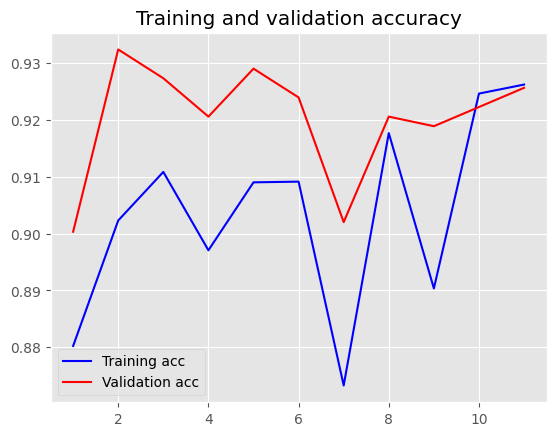

In [22]:
plot_accuracy(test_acc_lst,val_acc_lst)

In [67]:
df_news_Earnings = pd.read_csv("news_Earnings.csv")
df_news_Economic = pd.read_csv("news_Economic.csv")
df_news_StockMarket = pd.read_csv("
                                  news_StockMarket.csv")

X_news_Earnings = df_news_Earnings.test
X_news_Economic = df_news_Economic.test
X_news_StockMarket = df_news_StockMarket.test
Y_Earnings = encoder.fit_transform(df_news_Earnings.label)
Y_Economic=encoder.fit_transform(df_news_Economic.label)
Y_StockMarket=encoder.fit_transform(df_news_StockMarket.label)
train_data_earn = Datagen(X_news_Earnings, Y_Earnings, tokenizer, 50)
train_data_eco = Datagen(X_news_Economic, Y_Economic, tokenizer, 50)
train_data_sm = Datagen(X_news_StockMarket, Y_StockMarket, tokenizer, 50)
train_dataloader_earn = DataLoader(train_data_earn, batch_size=16, num_workers=2)
train_dataloader_eco = DataLoader(train_data_eco, batch_size=16, num_workers=2)
train_dataloader_sm = DataLoader(train_data_sm, batch_size=16, num_workers=2)
y_news_Earnings = predict(train_dataloader_earn,model)
y_news_Economic = predict(train_dataloader_eco,model)
y_news_StockMarket = predict(train_dataloader_sm,model)
df_news_Earnings['test_result'] = y_news_Earnings
df_news_Economic['test_result'] = y_news_Economic
df_news_StockMarket['test_result'] = y_news_StockMarket

In [69]:
df_news_Economic

,test,label,test_result
0,Tokyo Inflation Slows Ahead of BOJ Leadership ...,positive,negative
1,Fed Watchdog Launches Investigation Into SVB S...,neutral,neutral
2,Fed Officials See More Work on Inflation Despi...,neutral,positive
3,Colombia Hikes Interest Rate to 24-Year High t...,neutral,negative
4,"Australian Inflation Eases, Bolstering Case fo...",positive,negative
5,Goldman Sachs says the banking meltdown is a ‘...,positive,negative
6,Banking crisis has ‘definitely’ tipped the U.S...,negative,negative
7,Existing home sales jump in February as mortga...,positive,negative
8,Top economist Mohamed El-Erian warns that ‘ero...,negative,negative
9,Labor market: Workers are getting two jobs ami...,negative,negative


In [70]:
df_news_Earnings

,test,label,test_result
0,Homebuilder Lennar sees 'no disruption' in len...,positive,neutral
1,Media giants signal ad market 'stabilized' aft...,positive,positive
2,Costco Q2 earnings: Stock slips after mixed re...,neutral,negative
3,"Salesforce earnings: Company reports beats, st...",positive,positive
4,"Salesforce's activist investors: Who are they,...",neutral,neutral
5,J.M. Smucker CEO: PB&J is our 'bread & butter'...,positive,positive
6,HP earnings: Sales decline ‘driven by the macr...,negative,negative
7,"Warner Bros. Discovery sinks on earnings miss,...",negative,negative
8,Lucid earnings: Stock slides as EV-maker misse...,negative,negative
9,Shake Shack earnings come mostly in line with ...,neutral,neutral


In [71]:
df_news_StockMarket

,test,label,test_result
0,Zoetis Stock Could Rise 30% as People Spend Mo...,positive,positive
1,Dow Jones Rallies 250 Points; Lululemon Soars ...,positive,positive
2,"U.S. Stocks Open Higher, Following Internation...",positive,positive
3,Bank Crisis Credit Crunch Will Clip S&P 500 Ea...,negative,negative
4,Micron Stock Jumps Despite Sales Plunging 53%....,neutral,negative
5,Deere Is Sowing the Seeds of Success. Why the ...,positive,negative
6,TikTok parent ByteDance has special stock owne...,neutral,neutral
7,These Stocks Are Moving the Most Today: Micron...,neutral,neutral
8,Wall Street's sharks are circling 'dumb and gr...,negative,negative
9,Climate Funding Gets Squeezed by Volatile Markets,negative,negative
